In [1]:
import os
import scipy.io
import numpy as np
from numpy.linalg import norm
from scipy.spatial import distance
d=10000
## please download the data file from the following link: https://drive.google.com/file/d/1x1g4rA5dOoZ0NIaANwHlWseVIAM8ztHr/view?usp=sharing
mat = scipy.io.loadmat('Data/Text/DATA_EXAMPLE_PIPELINE_HD_10000_3.mat')
TR_D,TR_L,TS_D,TS_L=mat["TR_D"],mat["TR_L"],mat["TS_D"],mat["TS_L"]


In [2]:
DICTIONARY={
0:"Bulgarian",
1: "Czech",
2: "Danish",
3: "Dutch",
4: "German",
5: "English",
6: "Estonian",
7: "Finnish",
8: "French",
9: "Greec",
10: "Hungarian",
11: "Italian",
12: "Latvian",
13: "Lithuanian",
14: "Polish",
15: "Portuguese",
16: "Romanian",
17: "Slovak",
19: "Spanish",
20: "Swedish"
}

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.lines import Line2D  

def surf_plot(dist):
    fig, ax = plt.subplots(subplot_kw = {"projection": "3d"}, figsize = (12, 8))

    X = np.arange(0, len(dist), 1)
    Y = np.arange(0, len(dist[0]), 1)
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X, Y, dist, cmap = cm.coolwarm, linewidth = 0, antialiased = False)

    plt.gca().invert_yaxis()
    plt.show()
    
def level(x, q):
    lev = np.round(x * q)
    if(lev < q):
         lev += 1;
    return int(lev) - 1

def shp(a):
    print(a.shape)
    
def plot(mapp,numOfClasses,it,selectedClasses,updatedOrder):
    # print(mapp)
#     print("sda")
    global nodes
    # Supports upto 15 classes
    markers = [x[0] for x in list(Line2D.filled_markers)]
    fig = plt.figure()
    ax = fig.add_subplot()
    x = [-1, -1, nodes, nodes]
    y = [-1, nodes, -1,nodes]
    ax.scatter(x, y, marker = '.', color = 'none')
    cm = plt.get_cmap('gist_rainbow')
    colors = "bgrcmykw"
    j=0
    colorToClass={}
    for i in selectedClasses:
        ind = np.argwhere(mapp == (i+1))
        x = [t[0] for t in ind]
        y = [t[1] for t in ind]
        # ax.scatter(x, y, color = cm(i//3*3.0/21), label = DICTIONARY[i])
        ax.scatter(x, y, color = colors[j], label = DICTIONARY[i])
        colorToClass[(i+1)]=colors[j]
        j+=1
    for i in updatedOrder:
        ax.scatter(i["x"], i["y"],marker='x', color = colorToClass[i["class"]+1] , linewidths=2)
    ax.legend()
    plt.gcf().set_size_inches(8, 8)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
def R2P(x):
    return abs(x), np.angle(x)    

In [4]:
samplesPerClass=20

In [5]:
sim_nodes = 0.03#05
nodes = 30
nodes_tot = nodes * nodes

In [6]:

def cosineSimiliraty(a,b):
    return np.dot(a, np.conj(b))/(norm(a)*norm(b))

C:\Users\smkdr\AppData\Local\Temp/ipykernel_20408/2131262952.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  DIST[i][j] = cosineSimiliraty(HDind[ind][0],HDind[HDindReverse[(i,j)]])


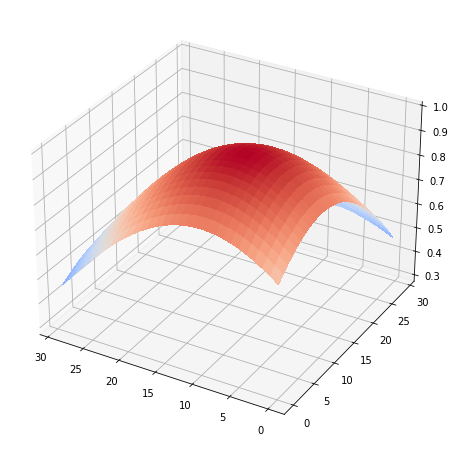

In [7]:
# Generate 2D map
np.random.seed(15)
# Reformat node ids - linear array of ids and array of coordinates for searching
 #12,2,63,71,83,86
X = 2 * np.pi * np.random.rand(1, d) # random angles
X = 1 * np.exp(1j * X) # create a phasor vector

Y = 2 * np.pi * np.random.rand(1, d) # random angles
Y = 1 * np.exp(1j * Y) # create a phasor vector
# print(X==Y)

HDind = np.zeros((nodes_tot, d), np.cfloat)
HDind_coord = np.zeros((nodes_tot, 2), float)
HDindReverse={}
cnt = 0
for i in range(nodes):
    for j in range(nodes):
        
#         tmp = circular_convolution(power(X, (sim_nodes * i)) , power(Y, (sim_nodes * j)))

        tmp = np.power(X, (sim_nodes * i)) * np.power(Y, (sim_nodes * j))
#         tmp/=norm(tmp)

#         tmp = power(X, (sim_nodes * i)) * power(Y, (sim_nodes * j))
        HDind[cnt] = tmp;
        HDind_coord[cnt][0] = i
        HDind_coord[cnt][1] = j
        HDindReverse[(i,j)]=cnt
        cnt += 1
# Visualize results for similarity between the nodes

DIST = np.zeros((nodes, nodes));
point = [10, 10]; # point of focus for visualization
ind = np.nonzero([np.all(val == point) for val in HDind_coord]); 

cnt = 0;
for i in range(nodes):
    for j in range(nodes):
        DIST[i][j] = cosineSimiliraty(HDind[ind][0],HDind[HDindReverse[(i,j)]])
        cnt += 1
    
surf_plot(DIST)

In [8]:
bmuInds=[]


bmuInds.append(HDindReverse[(0,0)])
bmuInds.append(HDindReverse[(0,nodes-1)])
bmuInds.append(HDindReverse[(nodes-1,0)])
bmuInds.append(HDindReverse[(nodes-1,nodes-1)])
np.random.shuffle(bmuInds)


In [9]:
import seaborn as sn
import pandas as pd
# ssss=set()
def train(SOM,TR_perm,TR_L_perm,bmuInds,num_of_classes,numSOMs):
    jj=0
    ## number of iterations (Actually number of updates)
#     itr=int(num_of_classes*1) #+(num_of_classes*2//3)
    itr=1;
    while(itr*numSOMs<num_of_classes):
        itr+=1
    itr=4#(itr*numSOMs)
#     itr=(itr*numSOMs)*2
    # itr=int(itr*1.5)
    print("Iterations: ",itr)
    updatedOrder=[]
    beta=1
    while(jj<itr):
        itrUpdate={}
        size_observe=(jj+1)*2
        ind_shuffled1 = np.random.permutation(len(TR_perm))

        arr=[]
        meanDist=[]
        for j in range(size_observe):
            ## pick a random sample from training set
            hd_new=TR_perm[ind_shuffled1[j]]
            maxiValues=[]
            for kk in range(numSOMs):
                
                Ibmu1 = [SOM[kk]]* np.conj(hd_new)
                ### find the best matching ind
                dist1= 1-distance.cdist(Ibmu1,HDind, 'cosine')
                ## maxi is the maximum similarity for the random sample

                maxi1, bmu_ind1 = np.max(dist1), np.argmax(dist1)
                maxiValues.append(maxi1)
            
            
            arr.append([max(maxiValues),ind_shuffled1[j]])


        arr=sorted(arr)
#         ### Select BMU - sample with the minium similarity in the current  subset for the given iteration
        ID =  arr[0][1]
        HD_NEW =TR_perm[ID]

        bmu_ind = bmuInds[jj]# np.random.randint(0, 10000)

        delta = HDind[bmu_ind] * HD_NEW
        SOM[jj%numSOMs] = SOM[jj%numSOMs] + delta #*0.4
        X,Y = HDind_coord[bmu_ind]
        itrUpdate['x']=X
        itrUpdate['y']=Y
        itrUpdate['class']=TR_L_perm[ID]
        jj+=1
        updatedOrder.append(itrUpdate)
#         print(TR_L_perm[ID])
#         ssss.add(TR_L_perm[ID])
#         print()
    return [SOM,updatedOrder]
def label(SOM,TR_perm,TR_L_perm,nodes,HDind_coord,numOfClasses,it,numSOMs,selectedClasses,updatedOrder):
    labelMap={}
    for k in range(len(TR_perm)):
        hd_new = TR_perm[k, :];
        #Ibmu - hypervector for Index of Best Matching Unit
        maxiValues=[]
        bmus=[]
        for kk in range(numSOMs):
            
            
            Ibmu1 = [SOM[kk]] * np.conj(hd_new); 
            dist1= 1-distance.cdist(Ibmu1,HDind, 'cosine')
            maxi1, bmu_ind1 = np.max(dist1), np.argmax(dist1)
            maxiValues.append(maxi1)
            bmus.append(bmu_ind1)
        maxiValues=np.array(maxiValues)
        bmu_ind = bmus[np.argmax(maxiValues)]
        
        inds= (HDind_coord[bmu_ind][0],HDind_coord[bmu_ind][1])
        if(inds in labelMap):
            labelMap[inds].append(TR_L_perm[k])
        else:
            labelMap[inds]=[TR_L_perm[k]]
#     labelMap={}
    for i in labelMap:
        a = np.array(labelMap[i])
        counts = np.bincount(a)
        labelMap[i]=np.argmax(counts)
    hmappAll = np.zeros((nodes, nodes), int)
    for x in labelMap:
        hmappAll[int(x[0])][int(x[1])]=labelMap[x]+1
    print("Train projection")
    plot(hmappAll,numOfClasses,it,selectedClasses,updatedOrder)
    labelIndexList=[]
    for i in labelMap:
        labelIndexList.append(HDindReverse[i])
    return [labelMap,labelIndexList]

    
def test(SOM,TS_D_perm,TS_L_perm,labelMap,numOfClasses,it,nodes,neighbourhood,hitList,labelIndexList,numSOMs,selectedClasses):   
    ITER = {}
    for i in selectedClasses:
        ITER[i]= {}
        for j in selectedClasses:
            ITER[i][j]=0
    for k in range(len(TS_D_perm)):
        hd_new = TS_D_perm[k, :];
        #Ibmu - hypervector for Index of Best Matching Unit
        
        maxiValues=[]
        bmus=[]
        for kk in range(numSOMs):
            
            
            Ibmu1 = [SOM[kk]] * np.conj(hd_new); 
            dist1= 1-distance.cdist(Ibmu1,hitList, 'cosine')
            maxi1, bmu_ind1 = np.max(dist1), labelIndexList[np.argmax(dist1)]
            maxiValues.append(maxi1)
            bmus.append(bmu_ind1)
        maxiValues=np.array(maxiValues)
        bmu_ind = bmus[np.argmax(maxiValues)]
        
        
        inds= (HDind_coord[bmu_ind][0],HDind_coord[bmu_ind][1])
        if(inds in labelMap):
#             print(labelMap[inds],TS_L_perm[k])
            ITER[TS_L_perm[k]][labelMap[inds]]+=1
        else:
            assert(1==0)
    finalVals=[]
    for i in selectedClasses:
        for j in selectedClasses:
            finalVals.append(ITER[i][j])
    finalVals=np.array(finalVals)
            
    
    return   [ITER ]  

Iterations:  4


C:\ProgramData\Anaconda3\lib\site-packages\scipy\spatial\distance.py:148: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)


Train projection


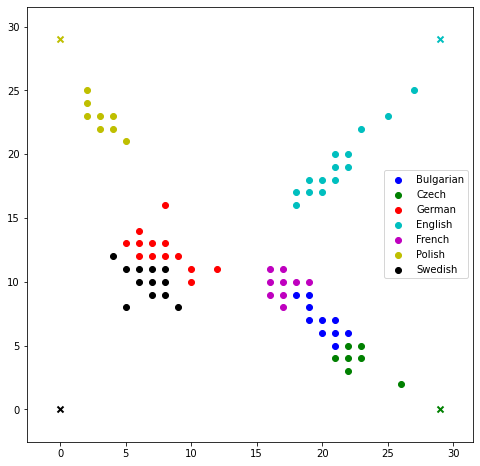

In [10]:
from numpy.linalg import norm
import numpy as np
from sklearn.model_selection import KFold


neighbourhood=3
selectedClasses = [0,1,4,5,8,14,20]


    
def cosineSimiliraty(a,b):
    return np.dot(a, np.conj(b))/(norm(a)*norm(b))

for numSOMs in [1]:#  [1,5,10,15,21]: #range(1, 11):
    np.random.seed(15)
    # SOM = np.zeros((1,d)) #1 * np.exp(1j * (2 * np.pi * np.random.rand(1, d))) # random initialization of the hypervector of SOM state
    SOM_2 = 1 * np.exp(1j * (2 * np.pi * np.random.rand(numSOMs, d))) # random initialization of the hypervector of SOM state
    [rho,theta] = R2P(SOM_2);        
    SOM_2 = 1 * np.exp(1j *theta)
    SOM_SAVED_2 = SOM_2.copy()
   
    
    for numOfClasses in  [6]:# range(2,22):

        D_TMP = np.concatenate(np.array([TR_D[(i)*20:(i+1)*20] for i in selectedClasses]),axis=0)
        L_PERM = np.concatenate(([[i]*samplesPerClass for i in selectedClasses]), axis = 0)

        D_T_TMP = np.concatenate(np.array([TS_D[(i)*10:(i+1)*10] for i in selectedClasses]),axis=0)
        L_T_PERM = np.concatenate(([[i]*(samplesPerClass//2) for i in selectedClasses]), axis = 0)

        kf = KFold(n_splits=5,shuffle=True)
        it=1
        accs=[]

        for i in range(1):
            inds1=np.random.permutation(len(D_TMP))
            inds2=np.random.permutation(len(D_T_TMP))
            TR_perm,TR_L_perm=D_TMP[inds1],L_PERM[inds1]
            TS_D_perm,TS_L_perm=D_T_TMP[inds2],L_T_PERM[inds2]
            SOM_2 = SOM_SAVED_2.copy()
            SOM_2,updatedOrder =train(SOM_2,TR_perm,TR_L_perm,bmuInds,numOfClasses,numSOMs)
            labelMap,labelIndexList = label(SOM_2,TR_perm,TR_L_perm,nodes,HDind_coord,numOfClasses,it,numSOMs,selectedClasses,updatedOrder)
            hitList = [HDind[j] for j in labelIndexList]
            ITER =test(SOM_2,TS_D_perm,TS_L_perm,labelMap,numOfClasses,it,nodes,neighbourhood,hitList,labelIndexList,numSOMs,selectedClasses)
            accs.append([it])
    #         break
            it+=1
        
